### Exploratory Analysis

In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
print(os.listdir("../input"))


['store.csv', 'train.csv', 'sample_submission.csv', 'test.csv']


In [48]:
store = pd.read_csv("../input/store.csv")
train = pd.read_csv("../input/train.csv",parse_dates=[2])
test = pd.read_csv("../input/test.csv",parse_dates=[3])
store.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(1115, 10)

In [49]:
# checking missing values, imputing numerical vals with median, categorical variables with mode
import numpy
from sklearn.base import TransformerMixin

# fill missing num values with median column values
store.fillna(store.median(), inplace=True)

# class to impute categorical variables
class SeriesImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        If the Series is of dtype Object, then impute with the most frequent object.
    
        """
    def fit(self, X, y=None):
        if   X.dtype == numpy.dtype('O'): self.fill = X.value_counts().index[0]
        return self

    def transform(self, X, y=None):
       return X.fillna(self.fill)

a  = SeriesImputer()   # Initialize the imputer
a.fit(store['PromoInterval'])  # Fit the imputer
store['PromoInterval'] = a.transform(store['PromoInterval'])   # Get a new series

# count the number of NaN values in each column after imputing
print(store.isnull().sum())

store.head()



Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct"
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct"
4,5,a,a,29910.0,4.0,2015.0,0,22.0,2012.0,"Jan,Apr,Jul,Oct"


CompetitionDistance         -0.018869
CompetitionOpenSinceMonth   -0.023638
CompetitionOpenSinceYear     0.010115
Promo2                      -0.091040
Promo2SinceWeek              0.032521
Promo2SinceYear             -0.004027
DayOfWeek                   -0.462125
Sales                        1.000000
Customers                    0.894711
Open                         0.678472
Promo                        0.452345
SchoolHoliday                0.085124
Name: Sales, dtype: float64


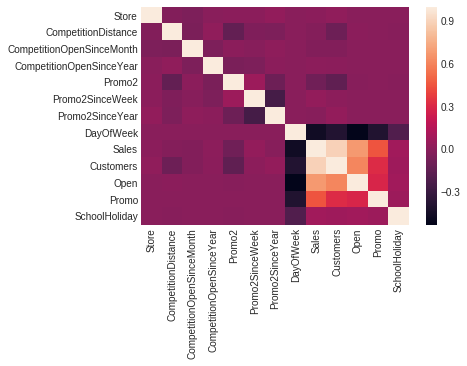

In [50]:
# exploratory analysis
import seaborn as sns
training = store.merge(train)

corr_df = training.corr()
sns.heatmap(corr_df)

corr_sales = training[training.columns[1:]].corr()['Sales'][:]
print(corr_sales)

Training period ranges from 2013-01-01 00:00:00 to 2015-07-31 00:00:00
Testing period ranges from 2015-08-01 00:00:00 to 2015-09-17 00:00:00 which is a period of 47 days 00:00:00


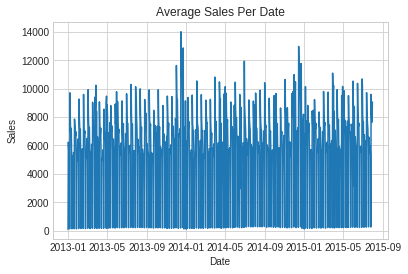

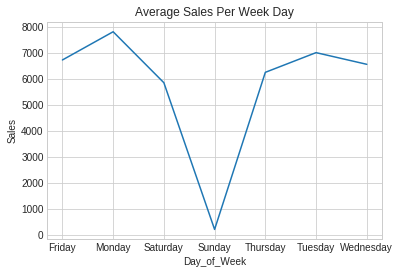

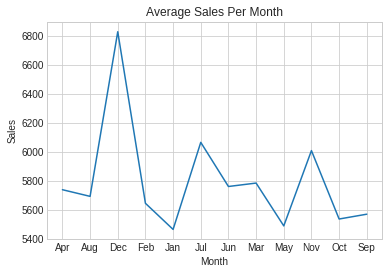

In [51]:
# note, 'customers' is not included in testing data, only training data
# exploring dates & sales

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

print("Training period ranges from" ,min(training['Date']), "to", max(training['Date']))
print("Testing period ranges from" ,min(test['Date']), "to", max(test['Date']), "which is a period of", max(test['Date']) - min(test['Date'])) 

# checking out sales by day
sales_by_date = training.groupby('Date')
means = sales_by_date.mean()
plt.plot(means['Sales'], linestyle='-')
plt.xlabel(means.index.name)
plt.ylabel('Sales')
plt.title('Average Sales Per Date')
plt.show()

# checking out sales per day of the week
training['Date'] = pd.to_datetime(training['Date'])
training['Day_of_Week'] = training['Date'].dt.day_name()
sales_by_weekday = training.groupby('Day_of_Week')
means2 = sales_by_weekday.mean()
plt.plot(means2['Sales'], linestyle='-')
plt.xlabel(means2.index.name)
plt.ylabel('Sales')
plt.title('Average Sales Per Week Day')
plt.show()

# checking out sales by month
training['Date'] = pd.to_datetime(training['Date'])
training['Month'] = training['Date'].dt.strftime('%b')

sales_by_month = training.groupby('Month')
means2 = sales_by_month.mean()
plt.plot(means2['Sales'], linestyle='-')
plt.xlabel(means2.index.name)
plt.ylabel('Sales')
plt.title('Average Sales Per Month')
plt.show()


#### Exploring Competition

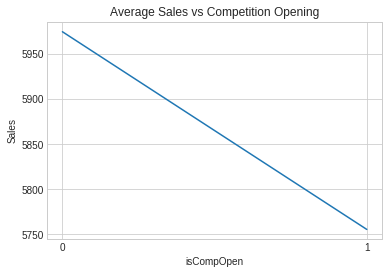

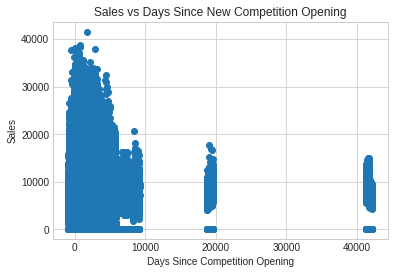

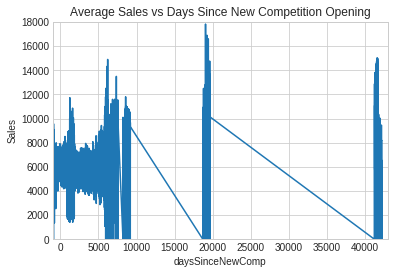

In [52]:
# Exploring Competition

training["CompOpenDate"] = training["CompetitionOpenSinceYear"].astype(str) + training["CompetitionOpenSinceMonth"].astype(str) + '1'
training['CompOpenDate'] = pd.to_datetime(training['CompOpenDate'])

def check_Comp(row):
    if row["Date"] >= row["CompOpenDate"]:
        return "1"
    else:
        return "0"
    
def num_days_comp(row):
    return row['Date'] - row['CompOpenDate']

training = training.assign(daysSinceNewComp=training.apply(num_days_comp, axis=1))
training['daysSinceNewComp'] = training['daysSinceNewComp'].dt.days
training = training.assign(isCompOpen=training.apply(check_Comp, axis=1))

# checking to see how much # of sales changes with new competition vs no competition 
sales_if_comp = training.groupby('isCompOpen')
means = sales_if_comp.mean()
plt.plot(means['Sales'], linestyle='-')
plt.xlabel(means.index.name)
plt.ylabel('Sales')
plt.title('Average Sales vs Competition Opening')
plt.show()

# checking how much sales change depending on how long competition has been open for
plt.scatter(training['daysSinceNewComp'], training['Sales'])
plt.xlabel("Days Since Competition Opening")
plt.ylabel('Sales')
plt.title('Sales vs Days Since New Competition Opening')
plt.show()

sales_days_comp = training.groupby('daysSinceNewComp')
means2 = sales_days_comp.mean()
plt.plot(means2['Sales'], linestyle='-')
plt.xlabel(means2.index.name)
plt.ylabel('Sales')
plt.xlim([-1000,43000])
plt.ylim([0, 18000])
plt.title('Average Sales vs Days Since New Competition Opening')
plt.show()






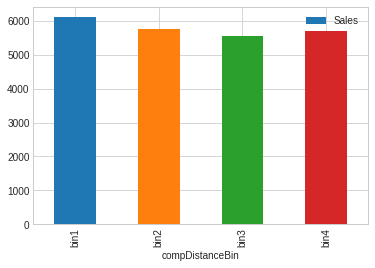

In [53]:
# Competition Distance
def comp_dist(row):
    if row["CompetitionDistance"] <= 710: # min to first quartile
        return "bin1"
    elif row["CompetitionDistance"] > 710 and row["CompetitionDistance"] <= 2325 : # first quartile to second quartile
        return "bin2"
    elif row["CompetitionDistance"] > 2325 and row["CompetitionDistance"] <= 6880 : # second quartile to third quartile
        return "bin3"
    elif row["CompetitionDistance"] > 6880 and row["CompetitionDistance"] <= 75860 : # third quartile to max
        return "bin4"

training = training.assign(compDistanceBin=training.apply(comp_dist, axis=1))

training.groupby('compDistanceBin').mean().plot(y='Sales', kind='bar')


#### Exploring Promos, Store Type

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


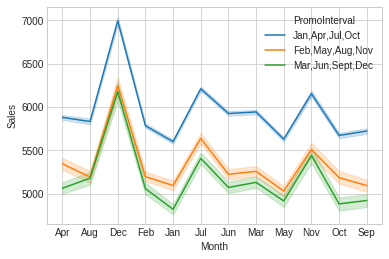

In [54]:
# compare promo length to # of sales
sns.lineplot(x="Month", y="Sales", hue="PromoInterval",data=training, estimator = np.mean)

In [ ]:
sns.lineplot(x="Month", y="Sales", hue="StoreType",data=training, estimator = np.mean)

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [ ]:
sns.lineplot(x="Month", y="Sales", hue="Promo2SinceWeek",data=training, estimator = np.mean)


In [ ]:
training.to_csv("training.csv", index=False)
